# Import Python modules

In [1]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import torch
import numpy as np
import tqdm
import utils
import networks
from dataloader import ImageDataloader, MultimodalDataloader

# Load processed data

In [2]:
data_dict = torch.load('data/image_csv_processed.pt')
image_dict = torch.load('data/images_processed.pt')

# Fit data to linear regression model

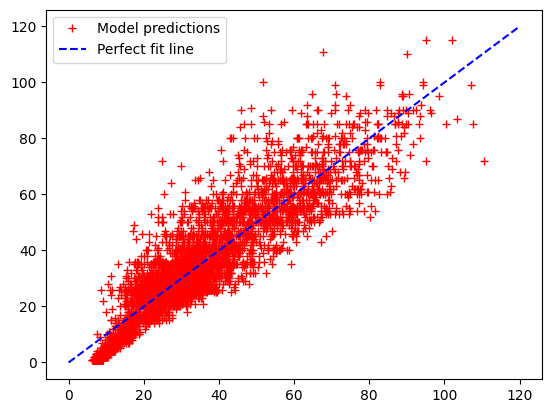

In [3]:
model = LinearRegression()

x_train = data_dict['x_train']
y_train = data_dict['y_train']
x_val = data_dict['x_val']
y_val = data_dict['y_val']

model = model.fit(x_train, y_train)

pred = model.predict(x_val)

plt.plot(pred, y_val, 'r+', label='Model predictions')
plt.plot([0, 120], [0, 120], 'b--', label='Perfect fit line')
plt.legend()

# Train images only with a CNN

In [4]:
x_train = image_dict['x_train_image']
x_val = image_dict['x_val_image']

image_batch_size = 16

train_dataloader = ImageDataloader(x = x_train, y = y_train, batch_size=image_batch_size, randomize=True)
val_dataloader = ImageDataloader(x = x_val, y = y_val, batch_size=image_batch_size, randomize=False)


model = networks.CNNRegression()

# instantiate your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# log your losses
train_losses = []
val_losses = []

# define how many epochs to train on
epochs = 10

# define your loss function for multiclass classification task
# BCE does binary cross entropy automatically for each class
loss_fn = torch.nn.MSELoss(reduction='none')

for _ in tqdm.tqdm(range(epochs)):
    losses = []
    for _ in range(train_dataloader.num_batches_per_epoch):
        # training data forward pass
        optimizer.zero_grad()
        train_batch = train_dataloader.fetch_batch()
        yhat = model(train_batch['x_batch'])
        train_loss = torch.mean(loss_fn(yhat, train_batch['y_batch']), dim=0)

        # training data backward pass
        train_loss.backward()
        optimizer.step()
        losses.append(train_loss.detach().numpy())

    # personally, I like to visualize the loss per every iteration, rather than every epoch. I find it more useful to diagnose issues
    train_losses.extend(losses)
    
    losses = []
    for _ in range(val_dataloader.num_batches_per_epoch):
        # validation data forward pass only
        val_batch = val_dataloader.fetch_batch()
        yhat = model(val_batch['x_batch'])
        val_loss = torch.mean(loss_fn(yhat, val_batch['y_batch']), dim=0)
        losses.append(val_loss.detach().numpy())
    # epoch-level logging for validation though usually makes the most sense
    val_losses.append(np.mean(losses))

8986     28_0_4_20170103213024052.jpg.chip.jpg
2834     20_1_0_20170117141304848.jpg.chip.jpg
2203      1_0_4_20170103210812538.jpg.chip.jpg
3445     22_0_4_20170103234043547.jpg.chip.jpg
21774     6_1_3_20161220223052131.jpg.chip.jpg
                         ...                  
21575    68_0_2_20170116193554465.jpg.chip.jpg
5390     25_1_0_20170117152038451.jpg.chip.jpg
860      16_0_0_20170110232038257.jpg.chip.jpg
15795    40_1_1_20170113011244319.jpg.chip.jpg
23654     9_0_0_20170120133313910.jpg.chip.jpg
Name: filename, Length: 14224, dtype: object <class 'pandas.core.series.Series'>
{'x_batch': tensor([[[[ 24.,  24.,  24.,  ...,  68.,  98.,  98.],
          [ 25.,  25.,  25.,  ...,  50.,  75.,  99.],
          [ 26.,  26.,  26.,  ...,  45.,  57.,  83.],
          ...,
          [ 24.,  24.,  23.,  ...,  23.,  19.,  23.],
          [ 24.,  23.,  23.,  ...,  20.,  23.,  21.],
          [ 23.,  22.,  22.,  ...,  22.,  25.,  22.]],

         [[ 29.,  29.,  29.,  ...,  65.,  96.,  9

100%|██████████| 10/10 [04:36<00:00, 27.62s/it]


Final validation loss: 222.59048


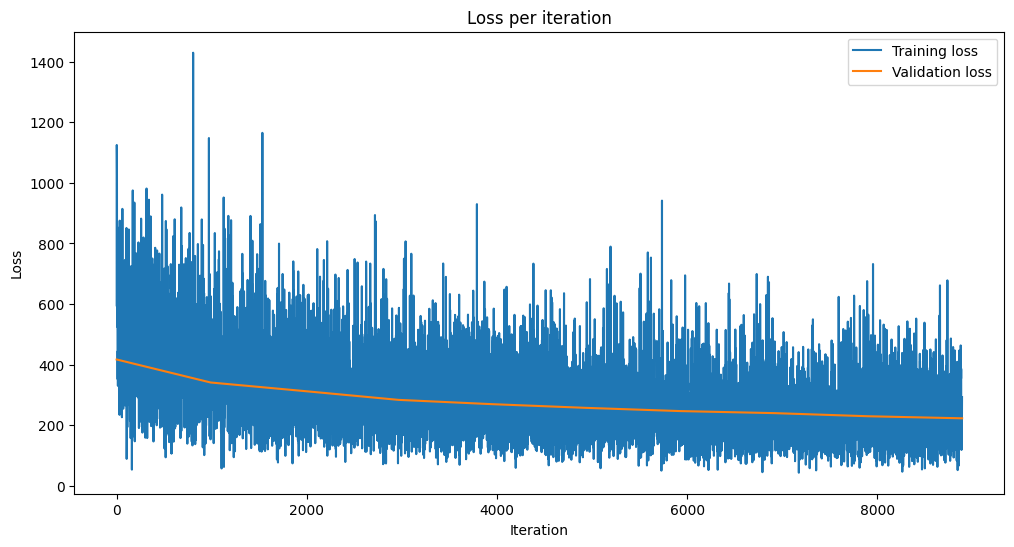

In [5]:
plt.figure(0, figsize = (12,6))
plt.title('Loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.plot(np.linspace(0,len(train_losses),epochs), val_losses)
plt.legend(["Training loss","Validation loss"])
print('Final validation loss:',val_losses[-1])

# Save checkpoint for model 2

In [6]:
model_state = model.state_dict()

torch.save(model_state, 'model_checkpoints/CNN.ckpt')

# Train images and CSV features with a multimodal neural network

In [4]:
x_train_image = image_dict['x_train_image']
x_val_image = image_dict['x_val_image']

image_batch_size = 16

train_dataloader = MultimodalDataloader(x = x_train, images=x_train_image, y = y_train, batch_size=image_batch_size, randomize=True)
val_dataloader = MultimodalDataloader(x = x_val, images=x_val_image, y = y_val, batch_size=image_batch_size, randomize=False)

model = networks.MultimodalNetwork()

# instantiate your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# log your losses
train_losses = []
val_losses = []

# define how many epochs to train on
epochs = 30

# define your loss function for multiclass classification task
# BCE does binary cross entropy automatically for each class
loss_fn = torch.nn.MSELoss(reduction='none')

for _ in tqdm.tqdm(range(epochs)):
    losses = []
    for _ in range(train_dataloader.num_batches_per_epoch):
        # training data forward pass
        optimizer.zero_grad()
        train_batch = train_dataloader.fetch_batch()
        yhat = model(train_batch['x_batch_image'], train_batch['x_batch'])
        train_loss = torch.mean(loss_fn(yhat, train_batch['y_batch']), dim=0)

        # training data backward pass
        train_loss.backward()
        optimizer.step()
        losses.append(train_loss.detach().numpy())

    # personally, I like to visualize the loss per every iteration, rather than every epoch. I find it more useful to diagnose issues
    train_losses.extend(losses)
    
    losses = []
    for _ in range(val_dataloader.num_batches_per_epoch):
        # validation data forward pass only
        val_batch = val_dataloader.fetch_batch()
        yhat = model(val_batch['x_batch_image'], val_batch['x_batch'])
        val_loss = torch.mean(loss_fn(yhat, val_batch['y_batch']), dim=0)
        losses.append(val_loss.detach().numpy())
    # epoch-level logging for validation though usually makes the most sense
    val_losses.append(np.mean(losses))

100%|██████████| 30/30 [03:34<00:00,  7.14s/it]


Final validation loss: 51.63426


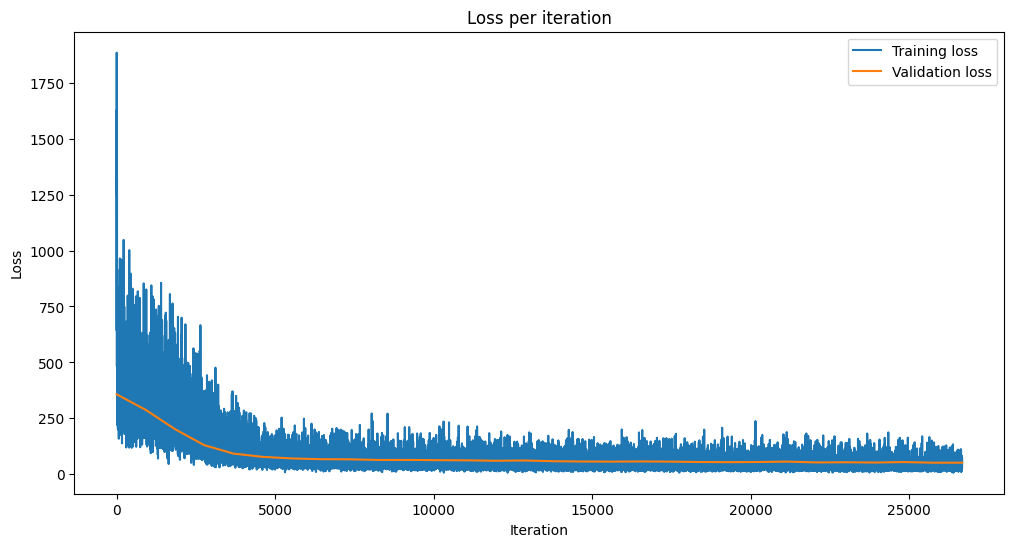

In [5]:
plt.figure(0, figsize = (12,6))
plt.title('Loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.plot(np.linspace(0,len(train_losses),epochs), val_losses)
plt.legend(["Training loss","Validation loss"])
print('Final validation loss:',val_losses[-1])

In [ ]:
model_state = model.state_dict()

torch.save(model_state, 'model_checkpoints/MultimodalNN.ckpt')